# Logistic regression

We will now develop a model, that will also allow us to solve the classification problem at hand, but that, at the same time, as a simple generalization to multilabel classification problems.

This is done by introducing the sigmoid/logistic function
$$\sigma:\mathbb{R}\rightarrow ]0,1[$$

defined by
$$\sigma(z)=\frac{1}{1+e^{-z}}\;.$$

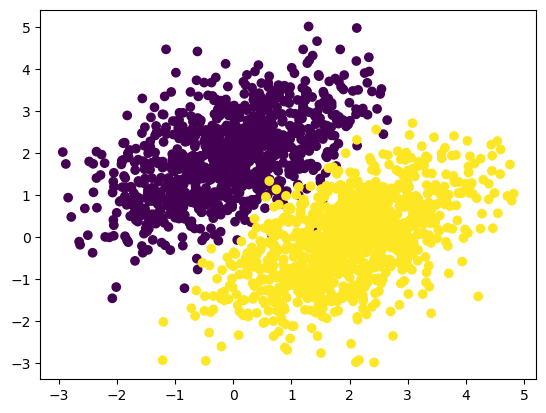

In [60]:
import numpy as np
import matplotlib.pyplot as plt

N= 1000

# Generate synthetic data
mean0 = np.array([0.,2.])
cov0 = np.array([[1., .5], [.5, 1]])
samples_clss0 = np.random.multivariate_normal(mean0,cov0,N)
mean1 = np.array([2.,0.])
cov1 = np.array([[1., .5], [.5, 1]])
samples_clss1 = np.random.multivariate_normal(mean1,cov1,N)


inputs = np.vstack((samples_clss0,samples_clss1))
labels = np.vstack((np.zeros((N,1)),np.ones((N,1)))).astype("float")

X1 = inputs[:,0]
X2 = inputs[:,1]

plt.scatter(X1,X2,c=labels[:,0])

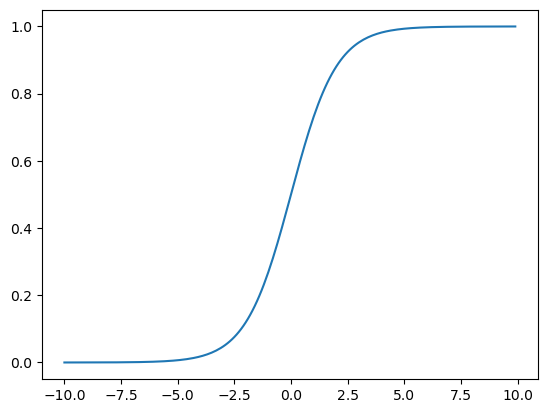

In [61]:


def sigmoid(z):
  return 1/(1+np.exp(-z))

zz = np.arange(-10,10,.1)
yy = sigmoid(zz)

plt.plot(zz,yy)

**The sigmoid neuron model**

We now construct a new model, a logistic model  (aka as the sigmoid neuron or sigmoid perceptron), by composing the linear model with the sigmoid function. This gives rise to a parameterized family of functions
$$f(\,\cdot\,;W,b):\mathbb{R}^{d_{in}}\rightarrow ]0,1[$$

defined by  

$$f(x;W,b) = \sigma(xW+b)\;.$$

Notice that the output lies in the range $]0,1[$ and in the context of a classification problem it's interpreted as the probability of input $x$ belonging to class $1$. In the context of neural networks this value is interpreted as the activation probability of the output neuron/unit.  



In [62]:
#Logistic Model (Neuron)
def model_logistic(X,W,b): 
  Z = np.matmul(X,W) + b # Linear combination
  Y = sigmoid(Z) # Activation function
  return Y

We have cast our (binary) classification problem into a probabilistic framework, where the outputs are probabilities of belonging to a given class, and the labels tell us, with probability $1$, to which class the input belongs.

An appropriate loss function to compare binary probability distributions is the **binary cross-entropy**: for a specific data input $x_k$, with output $y_k$ and label $t_k$, it is defined by the formula

$$ L_k = -t_k\log(y_k)-(1-t_k)\log(1-y_k)\;,$$

and in the entire data set we'll define it by taking the average of the previous quantities

$$L = \frac{1}{N}\sum_{k=1}^N L_k = - \frac{1}{N}\sum_{k=1}^N \Big(t_k\log(y_k)+(1-t_k)\log(1-y_k)\Big).$$

Notice that, as usual, the loss is a function of the model parameters $L=L(W,b)$.

In [63]:
#Binary Cross-Entropy Loss Function
def Loss_binary_cross_entropy(Y,T):
  Loss = np.mean(-T*np.log(Y)-(1-T)*np.log(1-Y))
  return Loss

To optimize this new model using gradient descent we need to compute the gradient of the binary cross-entropy loss with respect to the parameters of the sigmoid neuron; more precisely, the weights, collected in the vector $W\in\mathbb{R}^{d_{in}}$, and the bias $b\in\mathbb{R}$, which, in the current problem, is just a single parameter (Why?).

To do that we start by computing the derivative of the sigmoid function: In fat, if $y=\sigma(z)$ then (**Exercise**)

$$\frac{dy}{d z} = y(1-y)\;.$$

Now, let $w_{s}$ be one of the weights, then, using the chain rule,

$$\frac{\partial L_k}{\partial w_{s}} = \frac{\partial L_k}{\partial y_k}\frac{\partial y_k}{\partial z_k}\frac{\partial z_k}{\partial w_s}\;. $$

A computation (**Exercise**) leads to

$$\frac{\partial L_k}{\partial y_k} = \frac{y_k-t_k}{y_k(1-y_k)}$$

and since $y_k=\sigma(z_k)$ we get

$$\frac{\partial L_k}{\partial z_k} = \frac{\partial L_k}{\partial y_k}\frac{\partial y_k}{\partial z_k} = y_k-t_k\;,$$

which in view of its remarkable and useful simplicity we save for future use.

It is also clear that (see linear regression notebook)

$$\frac{\partial z_k}{\partial w_s} = x_{ks}\;,$$

where $x_{ks}$ is the $s$ component of the $k$'th input vector.

So we have  

$$\frac{\partial L_k}{\partial w_{s}} = x_{ks}(y_k-t_k)$$

and so

$$\frac{\partial L}{\partial w_{s}} = \frac{1}{N}\sum_{k=1}^N x_{ks}(y_k-t_k)$$

which we save in vectorial form

$$\frac{\partial L}{\partial W} = \frac{1}{N}X^t(Y-T)\;.$$

An analogous computation gives

$$\frac{\partial L}{\partial b} = \frac{1}{N}U^t(Y-T)\;,$$

where $U=[1\cdots 1]^t \in \mathbb{R}^N$.

These should be compared with the formulas for the gradient of the mean square loss wrt to the parameters of a linear model.

In [64]:
def grad_logistic(X,T,Y):
  N = X.shape[0]
  dLdW = (1/N)*np.matmul(X.T,Y-T)
  dLdb = (1/N)*np.matmul(np.ones((1,N)),Y-T)
  return dLdW, dLdb

In [65]:
#Functions for Training

def model_linear(X,W,b):
  Y = np.matmul(X,W)+b
  return Y

def Loss_mean_square(Y,T):
  Loss = np.mean(np.sum(np.square(Y-T),axis=1))
  return Loss

def parameter_init(d_in,d_out,std=1):
  W = np.random.normal(0,std,(d_in,d_out))
  b = np.zeros((1,d_out))
  return W, b

W, b = parameter_init(2,1)

def accuracy_binary(outputs,labels,trsh=.5):
  output = model_linear(inputs,W,b)
  predictions = outputs>trsh
  correct = predictions == labels
  accuracy = np.mean(correct)
  return accuracy

def myplot_2clss(inputs,labels,W,b,trsh=.5):
  xm = np.min(inputs[:,0])
  xM = np.max(inputs[:,0])
  ym = np.min(inputs[:,1])
  yM = np.max(inputs[:,1])
  xx = np.arange(xm,xM+.1,.1)
  yy = -(W[0,0]/W[1,0])*xx + (trsh - b[0,0])/W[1,0]
  plt.figure()
  plt.scatter(inputs[:,0],inputs[:,1],c=labels[:,0])
  plt.plot(xx,yy)
  plt.xlim(xm-1,xM+1)
  plt.ylim(ym-1,yM+1)

In [71]:
model = model_logistic
grad = grad_logistic
Loss = Loss_binary_cross_entropy
accuracy = accuracy_binary

def model_fit(X,T,W,b,num_epochs,lr):
  history_loss=[]
  for epoch in range(num_epochs):
    Y = model(X,W,b)
    dLdW, dLdb = grad(X,T,Y)
    W-=lr*dLdW
    b-=lr*dLdb
    if epoch % 10 == 0:
      print(f"epoch {epoch}"+f" Loss = {Loss(Y,T):.3f}"+f" Accuracy = {accuracy(Y,T):.3f}")
      history_loss.append(Loss(Y,T))
  print(f"Loss_final = {Loss(Y,T)}")
  print(f"Accuracy_final = {accuracy(Y,T)}")
  return history_loss

loss initial = 14.476848151633153
accuracy initial = 0.2275


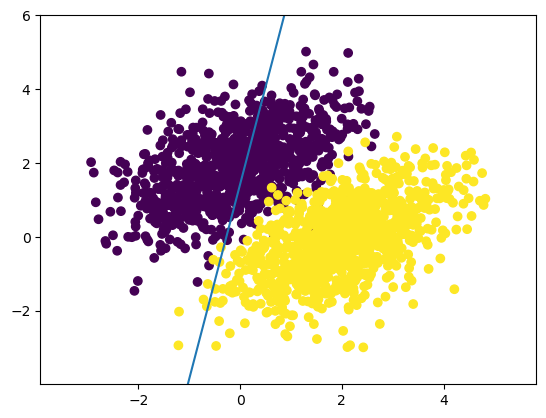

In [72]:
W,b = parameter_init(d_in=2,d_out=1)

outputs = model_linear(inputs,W,b)
print(f"loss initial = {Loss_mean_square(outputs,labels)}")
print(f"accuracy initial = {accuracy_binary(outputs,labels)}")

myplot_2clss(inputs,labels,W,b,trsh=.5)

epoch 0 Loss = 2.623 Accuracy = 0.172
epoch 10 Loss = 1.211 Accuracy = 0.296
epoch 20 Loss = 0.528 Accuracy = 0.802
epoch 30 Loss = 0.329 Accuracy = 0.976
epoch 40 Loss = 0.250 Accuracy = 0.983
epoch 50 Loss = 0.207 Accuracy = 0.985
epoch 60 Loss = 0.180 Accuracy = 0.987
epoch 70 Loss = 0.161 Accuracy = 0.986
epoch 80 Loss = 0.147 Accuracy = 0.986
epoch 90 Loss = 0.136 Accuracy = 0.986
Loss_final = 0.12791698159549267
Accuracy_final = 0.9855
[2.623301099924868, 1.2108282023337142, 0.5282203636145694, 0.3289650297686379, 0.2497818088380237, 0.2069432336944558, 0.1797498008477788, 0.16079106237122573, 0.14673241653401456, 0.13584116364605325]


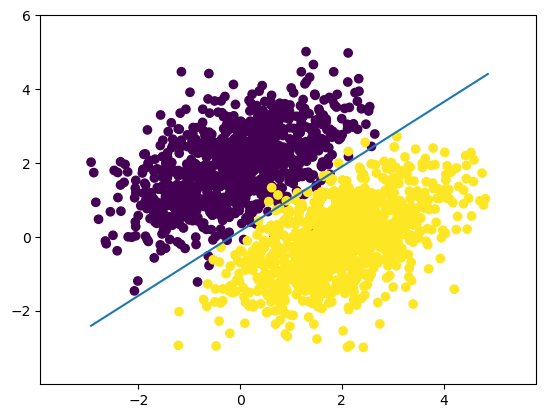

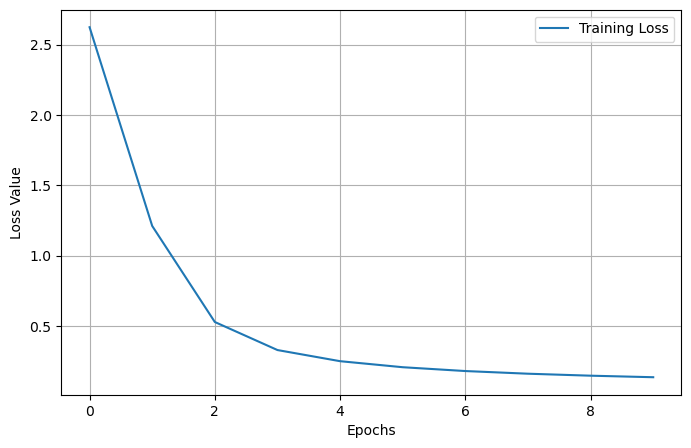

In [73]:
num_epochs = 100
lr = 1e-1
history=model_fit(inputs,labels,W,b,num_epochs,lr)
myplot_2clss(inputs,labels,W,b,trsh=0)
print(history)
plt.figure(figsize=(8, 5))
plt.plot(history, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)
plt.show()

# Multilabel classification

Now let us extend our framework to the context of classification problems with multiple labels.

As an example, in the next cell, we generate a synthetic data set with 3 labels.

/var/folders/rn/8y94k0ks60385yr7dq8lthyh0000gn/T/ipykernel_51850/134737221.py:14: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples_clss2 = np.random.multivariate_normal(mean2,cov2,N)


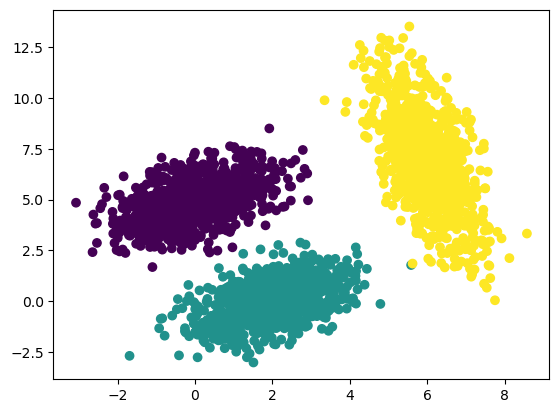

In [40]:
import numpy as np
import matplotlib.pyplot as plt

N= 1000

mean0 = np.array([0.,5.])
cov0 = np.array([[1., .5], [.5, 1]])
samples_clss0 = np.random.multivariate_normal(mean0,cov0,N)
mean1 = np.array([2.,0.])
cov1 = np.array([[1., .5], [.5, 1]])
samples_clss1 = np.random.multivariate_normal(mean1,cov1,N)
mean2 = np.array([6.,7.])
cov2 = np.array([[1., -5.], [-.5, 1.]])
samples_clss2 = np.random.multivariate_normal(mean2,cov2,N)

inputs = np.vstack((samples_clss0,samples_clss1,samples_clss2))
labels = np.vstack((np.zeros((N,1)),np.ones((N,1)),2*np.ones((N,1)))).astype("float")

X1 = inputs[:,0]
X2 = inputs[:,1]

plt.scatter(X1,X2,c=labels[:,0])

We will extend the useful probabilistic framework develop before.
In this context a general classification problem, with $m$ labels, will have inputs

$$x_k= [x_{k1}\cdots x_{k n}]\in \mathbb{R}^{n}$$

and labels of the form

$$t_k= [t_{k1}\cdots t_{km}]\in \mathbb{R}^{m}$$

that codify the fact that $x_k$ belongs to class $j$, by setting    

$$
t_{ks} =
\left\{
\begin{array}{l}
1 \quad , \text{ if } \quad  s = j \;,\\
0 \quad , \text{ if } \quad s \neq  j \;.
\end{array}
\right.
$$

This is known as **categorical representation** or **1-hot-encoding**.

In [ ]:
#One-Hot Encoding
def to_categorical(labels_integers):
  labels_integers = labels_integers.astype("int")
  N = labels_integers.shape[0]
  m = np.max(labels_integers)
  labels_categorical = np.zeros((N,m+1)) #Cria um array de zeros com N linhas e m+1 colunas
  labels_categorical[np.arange(N),labels_integers[:,0]] = 1
  return  labels_categorical

labels_categorical = to_categorical(labels)

labels_categorical[1990:2010]

A classifier is then a (parameterized) model

$$f(\,\cdot\,;W,b):\mathbb{R}^{n}\rightarrow \mathbb{P}^m\;,$$

where

$$\mathbb{P}^m :=\{y=(y_1,\ldots,y_m)\in\mathbb{R}^m\;|\; y_i\geq 0\;\; \text{ and }\;\; \sum_j y_j =1 \}$$
is the space of $m$-dimensional discrete probability distributions, i.e., a classifier assigns to each input a probability distribution over all classes.

Given such a classifier, we assign the label $l$ to the input $x$, provided $l = \text{argmax}(f(x))\;.$    


A simple and useful way to map vectors to $\mathbb{P}^m$ is provided by the softmax function

$$\text{softmax}:\mathbb{R}^m\rightarrow \mathbb{P}^m$$

whose $j\,$'th component is defined by

$$\text{softmax}_j(z_1,\ldots,z_m) = \frac{e^{z_j}}{\sum_{i=1}^m e^{z_i}}\;.$$


$$\text{softmax}(z_1-c,\ldots,z_m-c) = \text{softmax}(z_1\ldots,z_m)\;.$$

In [45]:
def softmax(Z):
  Z_res = Z - np.max(Z)
  Z_exp = np.exp(Z_res)
  return Z_exp/np.sum(Z_exp,axis = 1).reshape(Z.shape[0],1)

**A softmax layer**

We can now construct a new class of models by composing a linear model with the softmax function

$$f(\,\cdot\,;W,b):\mathbb{R}^{n}\rightarrow \mathbb{R}^m$$

defined by  

$$f(x;W,b) = \text{softmax}(xW+b)\;.$$

In [46]:
def model_softmax(X,W,b):
  Z = model_linear(X,W,b) # np.matmul(X,W,b)
  Y = softmax(Z)
  return Y  

In [48]:
#General accuracy function
def accuracy(outputs,labels_categorical):
  predictions = np.argmax(outputs, axis=1)
  labels_int = np.argmax(labels_categorical,axis=1)
  correct = predictions == labels_int
  accuracy = np.mean(correct)
  return accuracy

**Cross-entropy loss**

The cross-entropy loss has a natural generalization to this multilabel scenario: for a specific data input $x_k\in\mathbb{R}^n$, with output $y_k\in\mathbb{P}^m$ and label $t_k\in\mathbb{P}^m$, we define

$$ L_k = -\sum_{i=1}^m t_{ki}\log(y_{ki})$$

and, once again, in the entire data set we simply take the average and define

$$L = \frac{1}{N}\sum_{k=1}^N L_k = - \frac{1}{N}\sum_{k=1}^N \sum_{i=1}^m t_{ki}\log(y_{ki})\;.$$

In [47]:
def Loss_cross_entropy(Y,T):
  Loss = np.mean(np.sum(-T*np.log(Y),axis = 1))
  return Loss

Quite remarkably, the gradients of the the (general) cross-entropy loss with respect to the parameters of the softmax layer model satisfy the same formulas as before. Namely  

$$\frac{\partial L}{\partial W} = \frac{1}{N}X^t(Y-T)\;.$$

and

$$\frac{\partial L}{\partial b} = \frac{1}{N}U^t(Y-T)\;,$$

where $U=[1\cdots 1]^t \in \mathbb{R}^N\;$.

Notice, however, that now $\frac{\partial L}{\partial W}$ represents a matrix of derivatives and $\frac{\partial L}{\partial b}$ a vector of derivatives.

In [55]:
model = model_softmax
grad = grad_logistic # equal to grad_softmax
Loss = Loss_cross_entropy
accuracy = accuracy

def model_fit(X,T,W,b,num_epochs,lr):
  loss_history = []
  for epoch in range(num_epochs):
    Y = model(X,W,b)
    dLdW, dLdb = grad(X,T,Y)
    W-=lr*dLdW
    b-=lr*dLdb
    if epoch % 10 == 0:
      print(f"epoch {epoch}"+f" Loss = {Loss(Y,T):.3f}"+f" Accuracy = {accuracy(Y,T):.3f}")
      loss_history.append(Loss(Y,T))
  print(f"Loss_final = {Loss(Y,T)}")
  print(f"Accuracy_final = {accuracy(Y,T)}")
  return loss_history


def myplot_3clss(inputs,labels,W,b):
  plt.scatter(inputs[:,0],inputs[:,1],c=labels[:,0])
  xm = np.min(inputs[:,0])
  xM = np.max(inputs[:,0])
  ym = np.min(inputs[:,1])
  yM = np.max(inputs[:,1])
  xx = np.arange(xm,xM+.1,.1)
  yy10 = ((W[0,1]-W[0,0])*xx+(b[0,1]-b[0,0]))/(W[1,0]-W[1,1])  # see ex 6
  yy20 = ((W[0,2]-W[0,0])*xx+(b[0,2]-b[0,0]))/(W[1,0]-W[1,2])
  yy21 = ((W[0,2]-W[0,1])*xx+(b[0,2]-b[0,1]))/(W[1,1]-W[1,2])
  plt.plot(xx,yy10)
  plt.plot(xx,yy20)
  plt.plot(xx,yy21)
  plt.xlim(xm, xM)
  plt.ylim(ym,yM)  

/var/folders/rn/8y94k0ks60385yr7dq8lthyh0000gn/T/ipykernel_51850/2064962993.py:2: RuntimeWarning: invalid value encountered in log
  Loss = np.mean(np.sum(-T*np.log(Y),axis = 1))


loss initial = nan
accuracy initial = 0.007


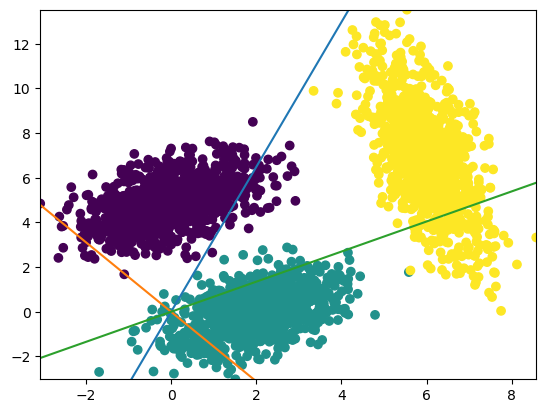

In [ ]:
#Initial parameters
W,b = parameter_init(d_in=2,d_out=3)

outputs = model_linear(inputs,W,b)
print(f"loss initial = {Loss_cross_entropy(outputs,labels)}")
print(f"accuracy initial = {accuracy(outputs,labels)}")

myplot_3clss(inputs,labels,W,b)

epoch 0 Loss = 1.052 Accuracy = 0.602
epoch 10 Loss = 0.294 Accuracy = 0.934
epoch 20 Loss = 0.253 Accuracy = 0.944
epoch 30 Loss = 0.226 Accuracy = 0.950
epoch 40 Loss = 0.205 Accuracy = 0.958
epoch 50 Loss = 0.190 Accuracy = 0.961
epoch 60 Loss = 0.177 Accuracy = 0.965
epoch 70 Loss = 0.166 Accuracy = 0.967
epoch 80 Loss = 0.157 Accuracy = 0.969
epoch 90 Loss = 0.149 Accuracy = 0.970
Loss_final = 0.14328697845844665
Accuracy_final = 0.971


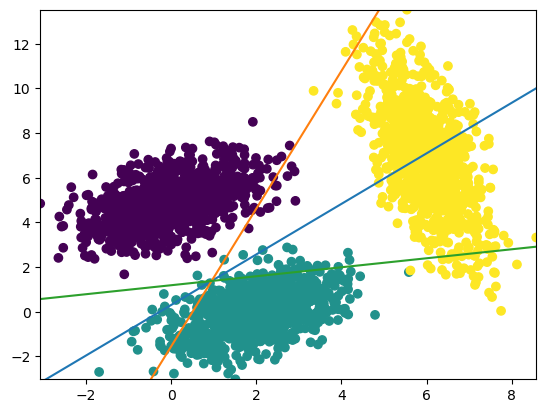

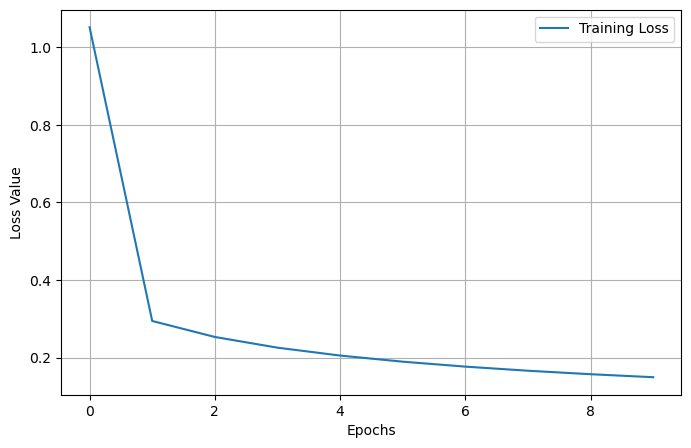

In [58]:
num_epochs = 100
lr = 1e-1
history = model_fit(inputs,labels_categorical,W,b,num_epochs,lr)

myplot_3clss(inputs,labels,W,b)

plt.figure(figsize=(8, 5))
plt.plot(history, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)
plt.show()
